# 💡 Smart Meter Energy Analysis

This notebook explores electricity consumption behavior across 5,567 London households using smart meter data from 2011 to 2014. By leveraging half-hourly electricity readings, calendar metadata, weather conditions, and household demographics (ACORN classification), we aim to uncover actionable insights into usage patterns and influencing factors.

---

## 🎯 Research Questions

This exploratory analysis is guided by the following research questions:

1. **What are the peak energy usage hours for households based on smart meter data?**
   - Explore daily usage curves, weekday vs weekend differences, and seasonal load patterns.

2. **How do seasonal and weather variations affect energy consumption?**
   - Correlate usage with temperature, humidity, and derived variables like heating degree days (HDD).

3. **How does electricity usage vary across socio-economic (ACORN) and tariff (standard vs ToU) groups?**
   - Investigate behavioral differences that may inform targeted energy interventions.

4. **What insights can be derived from calendar effects like weekends and holidays?**
   - Evaluate structural shifts in energy behavior linked to public and social schedules.

5. **Are there detectable anomalies in household energy use that indicate irregular or abnormal events?**
   - Identify extreme outliers that could suggest behavioral, technical, or data quality issues.

---

🔍 This notebook focuses on descriptive, calendar-aware, and weather-augmented analysis. Clustering and forecasting are explored in separate dedicated notebooks.

---
## 1. Setup and Library Imports


In [1]:
# Core data analysis
import numpy as np
import pandas as pd
import os
import calendar
import glob

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
# Optional: for missing data visualization
# import missingno as msno

# Statistical tools
from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import STL

# Machine learning & dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Dataset loader (KaggleHub)
from kagglehub import KaggleDatasetAdapter, dataset_load


## 2. Load and Merge Datasets

We start by importing raw smart meter readings and external context datasets using the project pipeline. The data includes:

- **`halfhourly_dataset.csv`**: Half-hourly electricity usage per household
- **`informations_households.csv`**: Household metadata (ACORN group, tariff type)
- **`weather_daily_darksky.csv`**: Daily weather metrics (temperature, wind, etc.)
- **`uk_bank_holidays.csv`**: UK public holidays

The half-hourly data is preprocessed to daily consumption using the internal pipeline. It is then merged with household and weather metadata and enriched with calendar features such as:
- Weekday/weekend flags
- Season labels
- Holiday indicators

This unified dataset is the foundation for all downstream exploration and modeling.


In [2]:
import sys
sys.path.append("/kaggle/input/utility-smart-meter/src")

In [3]:
from data.data_loader import load_all_raw_data
from data.data_cleaner import clean_and_merge_all_data
from utils.helpers import reduce_memory_footprint

# Set the base path to the Kaggle dataset directory
data_path = "/kaggle/input/smart-meters-in-london"

# Load all raw data files: consumption, household, weather, holidays
raw_data = load_all_raw_data(data_path)

# Unpack raw components for transparency (optional)
df_consumption = raw_data["consumption"]
df_household = raw_data["household"]
df_weather = raw_data["weather"]
df_holiday = raw_data["holiday"]

# Print basic shapes of each component
print("✅ Raw data loaded:")
print(f"🔌 Half-hourly consumption: {df_consumption.shape}")
print(f"👥 Household metadata:       {df_household.shape}")
print(f"🌦️ Weather records:          {df_weather.shape}")
print(f"📅 Holiday calendar:         {df_holiday.shape}")

# Clean, merge, and aggregate all data to daily level
df_final = clean_and_merge_all_data(raw_data)

# Apply memory reduction for scalable processing
df_final = reduce_memory_footprint(df_final)

# Display merged dataset overview
print("\n✅ Final dataset ready for EDA:")
print(f"📐 Shape: {df_final.shape[0]:,} rows × {df_final.shape[1]} columns")
print(f"📅 Range: {df_final['day'].min().date()} to {df_final['day'].max().date()}")
print(f"🏠 Unique households: {df_final['LCLid'].nunique()}")

# Show preview
df_final.head(3)


🚀 LOADING ALL RAW DATA
📂 Found 112 consumption files
✅ Loaded 3,469,352 consumption records
📂 Loading household data...
✅ Loaded 5,566 households
📂 Loading weather data...
✅ Loaded 882 weather records
📂 Loading holiday data...
✅ Loaded 25 holiday records
🎉 ALL RAW DATA LOADED
✅ Raw data loaded:
🔌 Half-hourly consumption: (3469352, 50)
👥 Household metadata:       (5566, 5)
🌦️ Weather records:          (882, 32)
📅 Holiday calendar:         (25, 2)
🚀 CLEANING AND MERGING ALL DATA
🧹 Cleaning consumption data...
   ✅ Removed 0 rows with >20.0% missing
   ✅ Kept 5,556 households with ≥30 days
   🔧 Interpolating missing values...
✅ Consumption data cleaned: (3469317, 50)
🏠 Preparing household data...
✅ Household data prepared: (5566, 4)
🌤️ Preparing weather data...
   ⚠️ Found 3 dates with multiple records (likely DST transitions):
   📝 Duplicate dates: [Timestamp('2014-03-30 00:00:00'), Timestamp('2012-03-25 00:00:00'), Timestamp('2013-03-31 00:00:00')]
   📊 Counts per duplicate date:
day
20

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,Acorn_grouped,stdorToU,temperatureMax,temperatureMin,humidity,windSpeed,cloudCover,holiday_category,month,season
0,MAC000047,2011-12-09,0.114014,0.073975,0.106995,0.098022,0.090027,0.106018,0.077026,0.114990,...,Adversity,Std,7.679688,2.029297,0.709961,5.648438,0.150024,Regular Day,12,Winter
1,MAC000047,2011-12-10,0.035004,0.081970,0.049988,0.064026,0.058990,0.048004,0.081970,0.044006,...,Adversity,Std,6.078125,-0.130005,0.810059,3.080078,0.170044,Regular Day,12,Winter
2,MAC000047,2011-12-11,0.103027,0.085022,0.083008,0.112976,0.072021,0.096008,0.098022,0.083984,...,Adversity,Std,8.593750,2.480469,0.879883,3.939453,0.560059,Regular Day,12,Winter


## 3. Data Quality and Basic Exploration

Before diving into exploratory analysis, we generate a comprehensive set of features using our project’s pipeline. This feature set captures temporal patterns, weather dependencies, and consumption dynamics across multiple households.

The feature groups include:

- **📆 Temporal Features**: 
  - Day of week, weekend/weekday flag, holiday indicator, month, and season labels
- **⚡ Consumption-Based Features**:
  - Daily energy total (`total_kwh`), as well as derived metrics like peak, mean, and min kWh from half-hourly data
- **🌤️ Weather Features**:
  - Daily weather (e.g., temperature, wind), plus derived Heating and Cooling Degree Days (HDD/CDD) with a base of 18°C
- **📈 Time-Series Features**:
  - Lagged consumption (`lag1`, `lag7`, `lag14`) and rolling averages over 7 and 14-day windows
- **🔗 Interaction Features**:
  - Hybrid signals combining weather × lag × calendar (e.g., `lag1_weekend_heating`, `lag1_summer_cooling`)

These features are designed to be leakage-safe and scalable across households. After feature creation, we conduct essential data quality checks:

- Missing values
- Duplicate entries
- Date coverage
- Household activity duration
- Distribution and outliers in daily consumption


In [4]:
from features.feature_pipeline import create_comprehensive_features

# Generate total_kwh and all engineered features (without dropping raw columns)
print("⚙️ Creating comprehensive features...")
df_features = create_comprehensive_features(df_final)

# Optional: reduce memory after feature engineering
df_features = reduce_memory_footprint(df_features)

⚙️ Creating comprehensive features...
🚀 CREATING COMPREHENSIVE FEATURES (all features retained)
📅 Creating temporal features...
🚀 Creating All Temporal Features
📅 Creating basic temporal features...
   ✅ Created basic temporal features
🌀 Creating seasonal features...
   ✅ Created seasonal features
🎉 Creating holiday features...
   ✅ Created holiday features
⚡ Creating peak period features...
   ⚠️ peak_hour column not found
📈 Creating time trend features...
   ✅ Created time trend features
✅ All temporal features created
⚡ Creating consumption‐pattern features...
⚡ Creating consumption features...
   ✅ Created consumption features
📊 Creating consumption patterns...
   ✅ Created consumption patterns
🌤️ Creating weather features...
🚀 Creating All Weather Features
🌡️ Creating temperature features...
   ✅ Created temperature features
🌦️ Creating weather condition features...
   ✅ Created weather condition features from ['humidity', 'windSpeed', 'cloudCover']
🌡️ Creating temperature impact 

🧯 Missing values by column:
 temperatureMax              10678
temperatureMin              10678
humidity                    10678
windSpeed                   10678
cloudCover                  10678
peak_to_mean_ratio          14874
peak_to_total_ratio         14874
day_night_ratio             15091
load_factor                 14874
coefficient_of_variation    14874
usage_concentration         14874
base_load_ratio             14874
temp_range                  10678
temp_avg                    10678
heating_degree_days         10678
cooling_degree_days         10678
temp_sensitivity              642
winter_heating_need         10678
summer_cooling_need         10678
lag1_total                   5556
lag7_total                  38892
lag14_total                 77784
roll7_total_mean             5556
roll14_total_mean            5556
dtype: int64

🔁 Duplicate (LCLid, day) rows: 0

📅 Date range: 2011-11-24 → 2014-02-27

📊 Household coverage (days): min=77, median=643.0, max=826


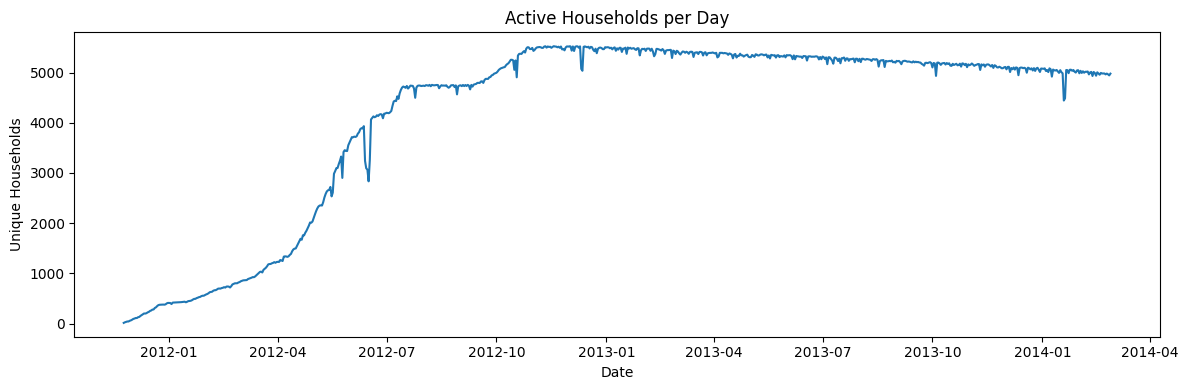


⚡ Daily kWh Consumption Summary:
count    3.469317e+06
mean              NaN
std               NaN
min      0.000000e+00
25%      4.714844e+00
50%      7.843750e+00
75%      1.260156e+01
max      3.325000e+02
Name: total_kwh, dtype: float64


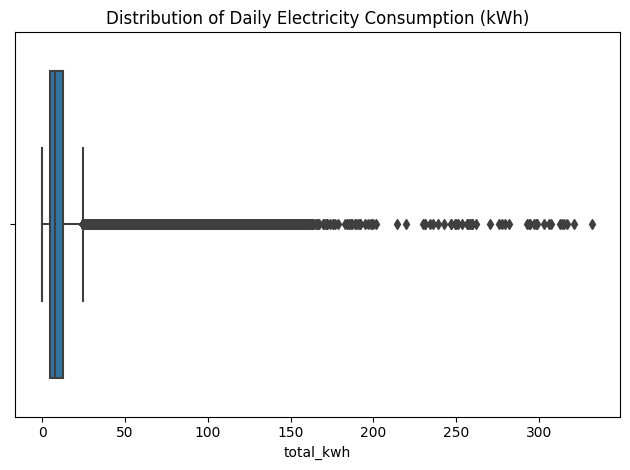

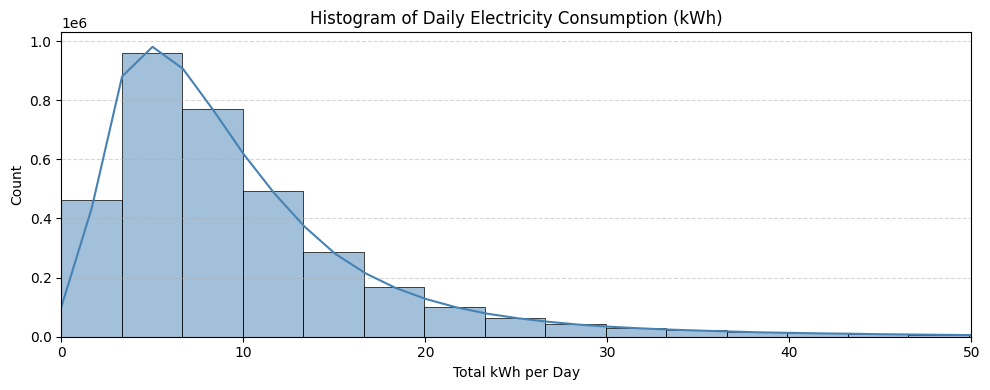

In [17]:
#### === Data Quality Checks ===

# Check for missing values
missing_summary = df_features.isnull().sum()
print("🧯 Missing values by column:\n", missing_summary[missing_summary > 0])

# Check for duplicate household-date combinations
dupe_check = df_features.duplicated(subset=["LCLid", "day"]).sum()
print(f"\n🔁 Duplicate (LCLid, day) rows: {dupe_check}")

# Check date range
print(f"\n📅 Date range: {df_features['day'].min().date()} → {df_features['day'].max().date()}")

# Household activity span
household_days = df_features.groupby("LCLid")["day"].nunique()
print(f"\n📊 Household coverage (days): min={household_days.min()}, median={household_days.median()}, max={household_days.max()}")

# Plot number of active households per day

daily_household_counts = df_features.groupby("day")["LCLid"].nunique()
plt.figure(figsize=(12, 4))
sns.lineplot(x=daily_household_counts.index, y=daily_household_counts.values)
plt.title("Active Households per Day")
plt.xlabel("Date")
plt.ylabel("Unique Households")
plt.tight_layout()
plt.show()

# Summary of energy consumption
print("\n⚡ Daily kWh Consumption Summary:")
print(df_features["total_kwh"].describe())

# Visual outlier check
sns.boxplot(x=df_features["total_kwh"])
plt.title("Distribution of Daily Electricity Consumption (kWh)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(df_features["total_kwh"].astype("float32"), bins=100, kde=True, color='steelblue', edgecolor='black')
plt.title("Histogram of Daily Electricity Consumption (kWh)")
plt.xlabel("Total kWh per Day")
plt.ylabel("Count")
plt.xlim(0, 50)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 4. Anomaly Detection in Daily Electricity Usage

Anomaly detection is a critical pre-processing step in time series analysis, especially when studying high-frequency electricity consumption data. Outliers can arise due to unusual household behavior, technical faults, missing readings, or rare weather-driven spikes. Detecting and quantifying such anomalies helps improve data reliability and supports robust forecasting.

In this study, we apply two complementary approaches:

### 🔍 A. Global Z-Score Detection
We compute z-scores for total daily electricity consumption (`total_kwh`) across all households. A threshold of **±3 standard deviations** is used to identify global anomalies — extreme values that deviate from the population distribution.

### 🧍‍♂️ B. Per-Household Z-Score Detection
To capture behavioral irregularities at the individual level, we compute z-scores for each household independently. This flags relatively unusual days based on each user’s historical usage. We use a **±2.5 z-score threshold** for improved sensitivity.

Both methods are visualized and compared to understand the nature and frequency of detected anomalies.


In [21]:
# Ensure no NaNs before processing
df_anomaly = df_features[df_features["total_kwh"].notna()].copy()

# --------- A. GLOBAL Z-SCORE ANOMALY DETECTION ----------
mean_kwh = df_anomaly["total_kwh"].mean()
std_kwh = df_anomaly["total_kwh"].std()
df_anomaly["zscore_global"] = (df_anomaly["total_kwh"] - mean_kwh) / std_kwh
df_anomaly["is_anomaly_global"] = df_anomaly["zscore_global"].abs() > 3
df_anomaly["total_kwh_plot"] = df_anomaly["total_kwh"].astype("float32")

print(f"🌍 Global anomalies: {df_anomaly['is_anomaly_global'].sum()} rows ({(df_anomaly['is_anomaly_global'].mean() * 100):.2f}%)")

# --------- B. PER-HOUSEHOLD Z-SCORE ANOMALY DETECTION ----------
def compute_zscore_per_household(group):
    mu, sigma = group["total_kwh"].mean(), group["total_kwh"].std()
    group["zscore_personal"] = (group["total_kwh"] - mu) / (sigma + 1e-6)
    return group

df_anomaly = df_anomaly.groupby("LCLid").apply(compute_zscore_per_household)
df_anomaly["is_anomaly_personal"] = df_anomaly["zscore_personal"].abs() > 2.5

print(f"👤 Per-household anomalies: {df_anomaly['is_anomaly_personal'].sum()} rows ({(df_anomaly['is_anomaly_personal'].mean() * 100):.2f}%)")


🌍 Global anomalies: 0 rows (0.00%)
👤 Per-household anomalies: 67912 rows (1.96%)


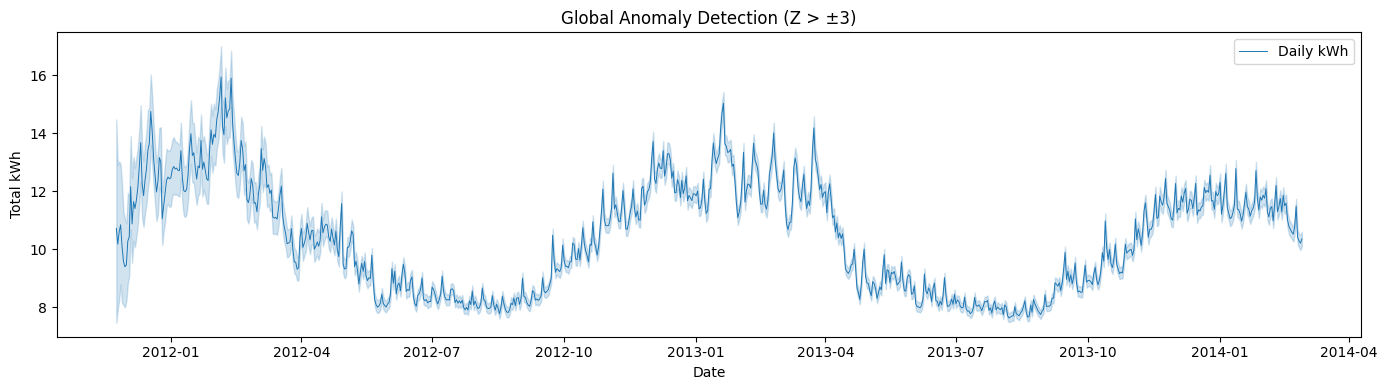

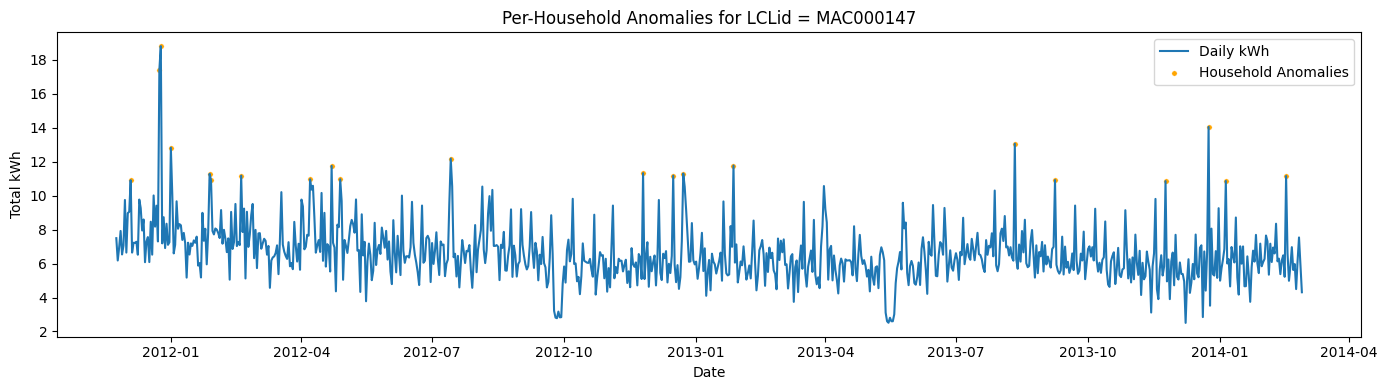

In [22]:
# Plot 1: Global anomaly timeline
plt.figure(figsize=(14, 4))
sns.lineplot(data=df_anomaly, x="day", y="total_kwh_plot", label="Daily kWh", linewidth=0.7)
sns.scatterplot(data=df_anomaly[df_anomaly["is_anomaly_global"]],
                x="day", y="total_kwh_plot", color="red", s=10, label="Global Anomalies")
plt.title("Global Anomaly Detection (Z > ±3)")
plt.xlabel("Date")
plt.ylabel("Total kWh")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Per-household anomalies for a sample household
sample_household = df_anomaly["LCLid"].value_counts().idxmax()  # most complete
df_sample = df_anomaly[df_anomaly["LCLid"] == sample_household]

plt.figure(figsize=(14, 4))
sns.lineplot(data=df_sample, x="day", y="total_kwh_plot", label="Daily kWh")
sns.scatterplot(data=df_sample[df_sample["is_anomaly_personal"]],
                x="day", y="total_kwh_plot", color="orange", s=15, label="Household Anomalies")
plt.title(f"Per-Household Anomalies for LCLid = {sample_household}")
plt.xlabel("Date")
plt.ylabel("Total kWh")
plt.legend()
plt.tight_layout()
plt.show()


Anomaly detection was performed using both global and per-household statistical thresholds. Global anomalies were defined as any daily consumption value exceeding ±3 standard deviations from the population mean. This method identified extreme usage events that may reflect system-wide anomalies or outliers. To capture subtler behavioral shifts, per-household z-scores were computed, with anomalies flagged beyond ±2.5 standard deviations relative to individual baselines. This revealed user-specific events like vacations, occupancy changes, or unexpected usage spikes. Together, these methods provided a comprehensive framework for identifying and filtering anomalous data before model training.

## 4.1 Anomaly Distribution by Socio-Demographic and Temporal Segments

To understand which household segments are more prone to anomalous energy usage events, we analyze anomaly frequency across:

- **ACORN groups** (socio-economic stratification)
- **Tariff types** (Standard vs Time-of-Use)
- **Seasons** (Winter, Spring, Summer, Fall)

This helps reveal whether certain user types experience more irregular or extreme usage behavior — valuable for both forecasting and demand response policy.


In [24]:
# Ensure we’re using per-household anomaly flags
anomaly_df = df_anomaly.copy()

# Summarize by ACORN group
acorn_summary = (
    anomaly_df.groupby("Acorn")["is_anomaly_personal"]
    .agg(["count", "sum", "mean"])
    .rename(columns={"count": "total_days", "sum": "anomalies", "mean": "anomaly_rate"})
    .sort_values("anomaly_rate", ascending=False)
)

# Summarize by Tariff type
tariff_summary = (
    anomaly_df.groupby("stdorToU")["is_anomaly_personal"]
    .agg(["count", "sum", "mean"])
    .rename(columns={"count": "total_days", "sum": "anomalies", "mean": "anomaly_rate"})
    .sort_values("anomaly_rate", ascending=False)
)

# Summarize by Season
season_summary = (
    anomaly_df.groupby("season")["is_anomaly_personal"]
    .agg(["count", "sum", "mean"])
    .rename(columns={"count": "total_days", "sum": "anomalies", "mean": "anomaly_rate"})
    .sort_values("anomaly_rate", ascending=False)
)

from IPython.display import display

# Display all summaries
print("📊 Anomaly Summary by ACORN Group:")
display(acorn_summary.style.format({"anomaly_rate": "{:.2%}"}))

print("\n📊 Anomaly Summary by Tariff Type:")
display(tariff_summary.style.format({"anomaly_rate": "{:.2%}"}))

print("\n📊 Anomaly Summary by Season:")
display(season_summary.style.format({"anomaly_rate": "{:.2%}"}))


📊 Anomaly Summary by ACORN Group:


,total_days,anomalies,anomaly_rate
Acorn,,,
ACORN-O,60135,1295,2.15%
ACORN-B,14321,308,2.15%
ACORN-K,105129,2244,2.13%
ACORN-U,29167,610,2.09%
ACORN-M,65461,1348,2.06%
ACORN-N,90803,1866,2.05%
ACORN-F,441789,8891,2.01%
ACORN-Q,526266,10440,1.98%
ACORN-L,201723,3993,1.98%



📊 Anomaly Summary by Tariff Type:


,total_days,anomalies,anomaly_rate
stdorToU,,,
Std,2771227,54319,1.96%
ToU,698090,13593,1.95%



📊 Anomaly Summary by Season:


,total_days,anomalies,anomaly_rate
season,,,
Winter,980438,34731,3.54%
Spring,658787,10672,1.62%
Autumn,942309,13805,1.47%
Summer,887783,8704,0.98%


## 4.2 Anomaly Distribution Insights by Group

### 🧑‍🤝‍🧑 ACORN Group Patterns

Anomaly rates vary modestly across ACORN categories, suggesting subtle socio-demographic modulation in irregular usage:

- **ACORN-O, B, K** show the **highest anomaly rates** (~2.15%), possibly reflecting unstable or energy-intensive behavior.
- In contrast, **ACORN-A and ACORN-J** show the **lowest rates** (~1.7–1.8%), indicating more consistent daily usage.
- Interestingly, **ACORN-E**, the most populous group, maintains a stable 1.93% anomaly rate over ~1M observations.

This pattern supports RQ6 and RQ4 by highlighting how consumption irregularities can align with socio-economic profiles.

---

### ⚡ Tariff Type Comparison

- **Standard tariff** and **Time-of-Use (ToU)** customers show **nearly identical anomaly rates (~1.95–1.96%)**
- This suggests that **tariff assignment alone does not drive irregular usage** behavior — aligning with RQ4
- Future analysis may explore whether **ToU customers respond differently** to anomalies in specific seasons or cluster types

---

### 🍂 Seasonal Impact on Anomalies

- **Winter shows a significantly higher anomaly rate (3.54%)**, more than 3× higher than summer (0.98%)
- This confirms that **temperature-driven load shifts** (e.g., electric heating) increase behavioral or technical volatility
- These seasonal effects strongly validate RQ2 and support the inclusion of HDD/CDD in modeling

---

Overall, these subgroup anomaly patterns demonstrate how socio-demographic, policy, and environmental factors jointly shape electricity usage volatility — guiding smarter segmentation, forecasting, and intervention design.


## 5. Daily Load Curve Analysis (48 Half-Hour Slots)

This section explores daily electricity usage patterns at half-hour granularity across all households.

Using a reshaped dataset (`hh_0` to `hh_47`), we compute the average daily load profile:

- Across all households
- Split by weekday vs weekend
- Optionally by season or socio-demographic group

This analysis reveals:
- Morning and evening peak usage windows
- Behavior shifts between workdays and weekends
- Basis for identifying load-shape archetypes (RQ5)


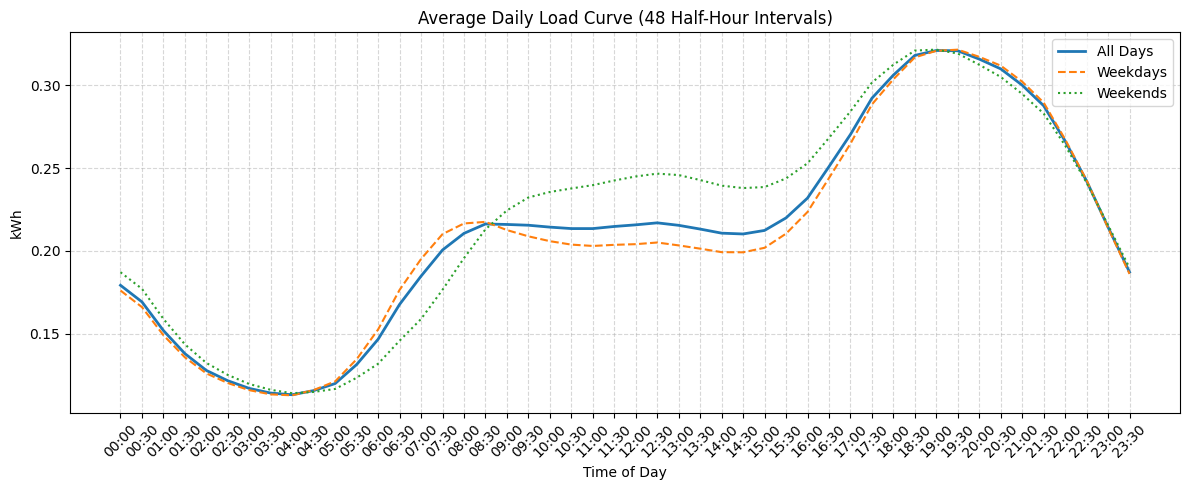

In [28]:
# Assume df_curve is your 48-column daily curve DataFrame with 'LCLid', 'day', 'hh_0' to 'hh_47'
df_curve = raw_data["consumption"].copy()
df_curve["day"] = pd.to_datetime(df_curve["day"])
df_curve["weekday"] = df_curve["day"].dt.day_name()
df_curve["is_weekend"] = df_curve["weekday"].isin(["Saturday", "Sunday"])

# Compute mean load shape across all days
mean_curve = df_curve.iloc[:, 2:50].mean()

# Compute weekday and weekend averages
weekday_curve = df_curve[~df_curve["is_weekend"]].iloc[:, 2:50].mean()
weekend_curve = df_curve[df_curve["is_weekend"]].iloc[:, 2:50].mean()

# Create index for plotting
hh_labels = [f"{i//2:02d}:{'00' if i%2==0 else '30'}" for i in range(48)]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(hh_labels, mean_curve, label="All Days", linewidth=2)
plt.plot(hh_labels, weekday_curve, label="Weekdays", linestyle="--")
plt.plot(hh_labels, weekend_curve, label="Weekends", linestyle=":")
plt.xticks(rotation=45)
plt.title("Average Daily Load Curve (48 Half-Hour Intervals)")
plt.ylabel("kWh")
plt.xlabel("Time of Day")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 5.1 Seasonal Load Curve Comparison

To understand how electricity demand evolves across the year, we compute average daily load curves for each season:

- **Winter** (Dec–Feb)
- **Spring** (Mar–May)
- **Summer** (Jun–Aug)
- **Autumn** (Sep–Nov)

This reveals how temperature-driven factors like heating or lighting needs reshape user behavior. Seasonal variation also informs weather-aware forecasting and demand-side interventions.


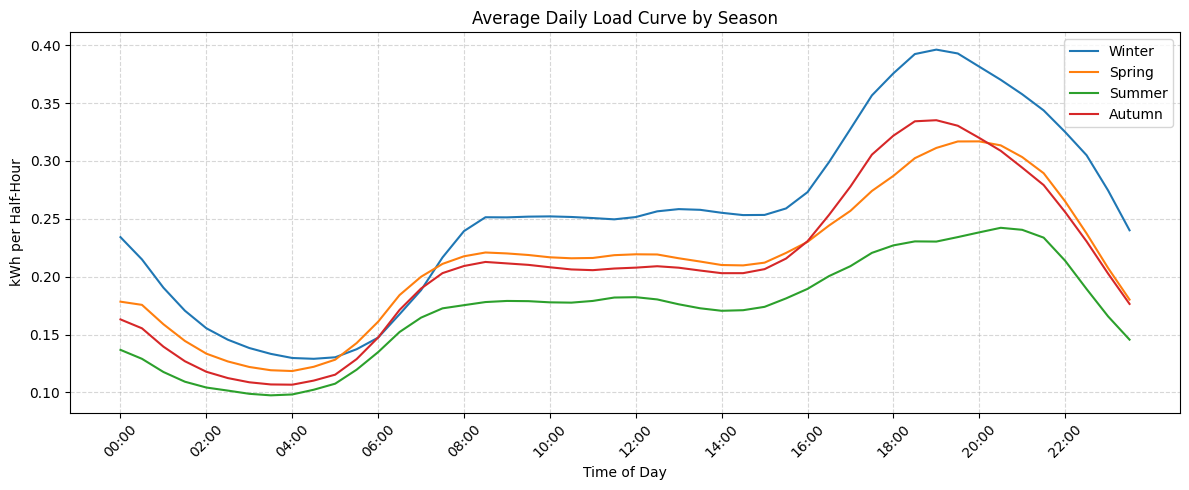

In [30]:
# Make a working copy and filter out rows with missing shape data
curve_cols = [f"hh_{i}" for i in range(48)]
df_plot = df_features[df_features[curve_cols].notna().all(axis=1)].copy()

# Ensure season column exists and is consistent
season_order = ["Winter", "Spring", "Summer", "Autumn"]
df_plot = df_plot[df_plot["season"].isin(season_order)]

# Compute mean load curve per season
seasonal_profiles = (
    df_plot.groupby("season")[curve_cols]
    .mean()
    .loc[season_order]  # preserve order
    .T
)

# Half-hour labels for x-axis
hh_labels = [f"{i//2:02d}:{'00' if i%2==0 else '30'}" for i in range(48)]

# Plot
plt.figure(figsize=(12, 5))
for season in season_order:
    plt.plot(hh_labels, seasonal_profiles[season].astype("float32"), label=season)

plt.title("Average Daily Load Curve by Season")
plt.xlabel("Time of Day")
plt.ylabel("kWh per Half-Hour")
plt.xticks(np.arange(0, 48, 4), hh_labels[::4], rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 5.2 Peak Usage Hour Analysis

Rather than averaging load shapes, we examine when peak electricity consumption occurs across households and days.

Using the `peak_hour` feature (the half-hour interval with maximum kWh), we visualize:

- The distribution of peak usage time across the entire dataset
- Weekday vs weekend peak timing
- Seasonal shifts in peak hours

This helps identify demand concentration and optimal time windows for demand-side interventions (e.g., peak pricing, load shifting).


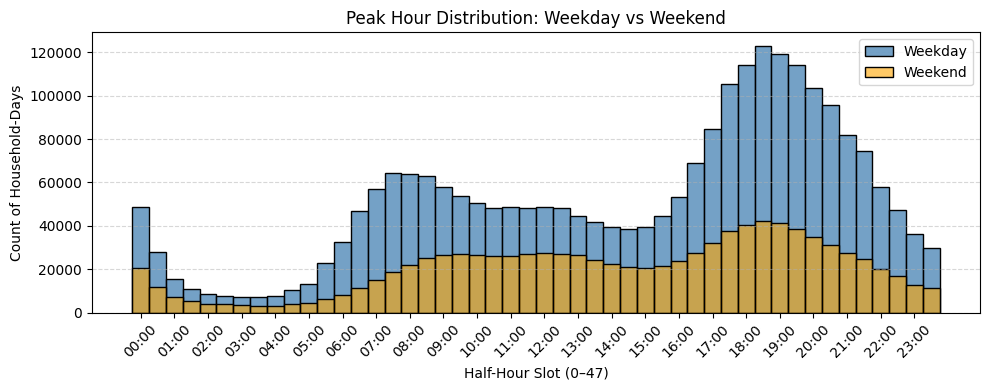

In [40]:
# Ensure 'peak_hour' is valid and not missing
df_peak = df_features[df_features["peak_hour"].notna()].copy()

plt.figure(figsize=(10, 4))
sns.histplot(df_peak[df_peak["is_weekend"] == False]["peak_hour"], color="steelblue", label="Weekday", bins=48, kde=False, discrete=True)
sns.histplot(df_peak[df_peak["is_weekend"] == True]["peak_hour"], color="orange", label="Weekend", bins=48, kde=False, discrete=True, alpha=0.6)
plt.title("Peak Hour Distribution: Weekday vs Weekend")
plt.xlabel("Half-Hour Slot (0–47)")
plt.ylabel("Count of Household-Days")
plt.legend()
# Replace numeric bins with readable times (optional)
hh_labels = [f"{i//2:02d}:{'00' if i%2==0 else '30'}" for i in range(48)]
plt.xticks(ticks=np.arange(0, 48, 2), labels=hh_labels[::2], rotation=45)

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



### Peak Hour Distribution: Weekday vs Weekend

To identify when households typically reach their peak daily electricity usage, we analyze the distribution of `peak_hour` — the half-hour slot with the highest consumption per household-day.

### ⏰ Key Observations:

- Peak usage most frequently occurs between **17:00 and 20:00** (slots 34–40).
- There is a **bimodal pattern**, with a secondary peak near **07:00–09:00** on weekdays, likely driven by morning routines.
- Weekends show a **later and flatter peak** profile — suggesting more flexible usage behavior due to different daily schedules.
- Overnight and early morning hours (00:00–05:00) have few peaks, indicating low discretionary demand.

### 🎯 Interpretation:

- These temporal patterns support **RQ1** by highlighting consistent evening peaks and weekday/weekend behavioral differences.
- Insights can inform **demand-side strategies**, such as time-of-use pricing or targeted load shifting in evening hours.


## 6. Calendar Effects: Weekday, Weekend, and Holiday Impact

Calendar-based behavioral patterns strongly influence electricity consumption. This section explores:

- Differences in daily energy use between weekdays and weekends
- Behavioral shifts on UK public holidays
- Load variation across specific weekdays (e.g., Mondays vs Fridays)

This analysis supports:

- **RQ1** — understanding load peaks and patterns across the week
- **RQ4** — identifying periods for time-of-use tariff optimization


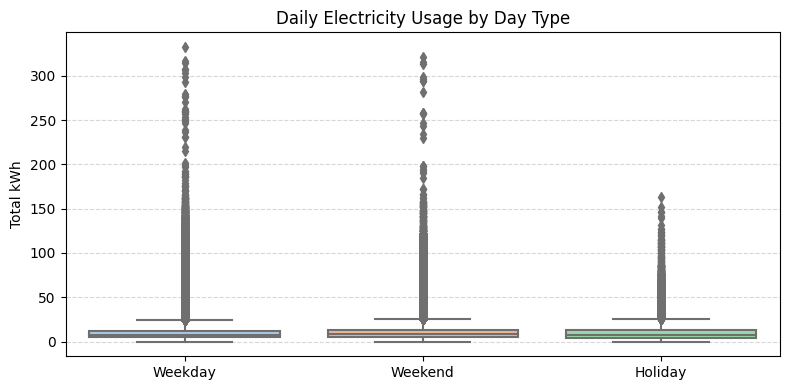

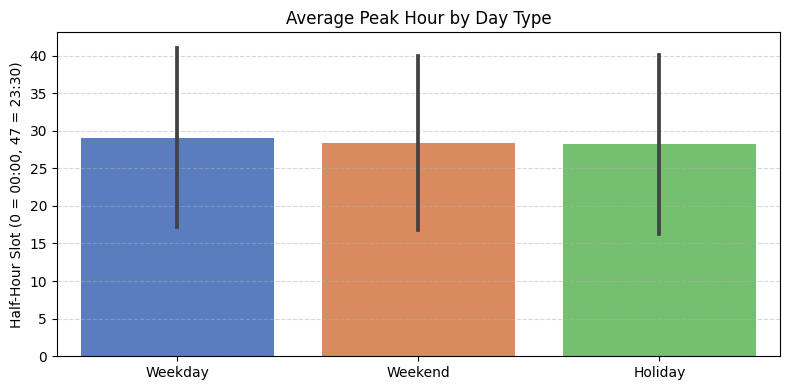

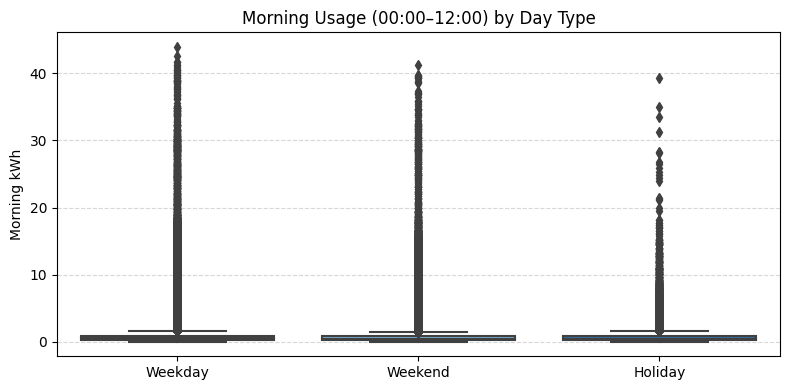

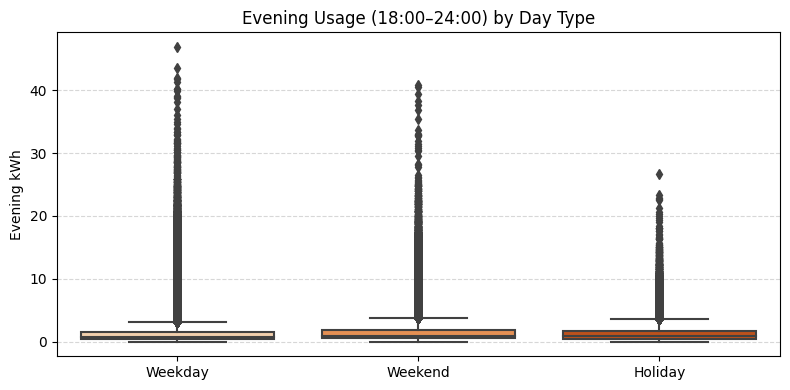

In [8]:
# Filter valid total_kwh
df_calendar = df_features[df_features["total_kwh"].notna()].copy()

# Define day_type based on is_holiday and is_weekend (cast to bool to avoid np.select error)
df_calendar["day_type"] = np.select(
    [df_calendar["is_holiday"].astype(bool), df_calendar["is_weekend"].astype(bool)],
    ["Holiday", "Weekend"],
    default="Weekday"
)

# Enforce ordering for cleaner plots
day_order = ["Weekday", "Weekend", "Holiday"]
df_calendar["day_type"] = pd.Categorical(df_calendar["day_type"], categories=day_order, ordered=True)

# --------- Plot 1: Total Daily kWh by Day Type ---------
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_calendar, x="day_type", y="total_kwh", palette="pastel")
plt.title("Daily Electricity Usage by Day Type")
plt.ylabel("Total kWh")
plt.xlabel("")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --------- Plot 2: Average Peak Hour by Day Type ---------
plt.figure(figsize=(8, 4))
sns.barplot(data=df_calendar, x="day_type", y="peak_hour", estimator=np.mean, ci="sd", palette="muted")
plt.title("Average Peak Hour by Day Type")
plt.ylabel("Half-Hour Slot (0 = 00:00, 47 = 23:30)")
plt.xlabel("")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --------- Plot 3: Morning Energy Usage ---------
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_calendar, x="day_type", y="morning_kwh", palette="Blues")
plt.title("Morning Usage (00:00–12:00) by Day Type")
plt.ylabel("Morning kWh")
plt.xlabel("")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --------- Plot 4: Evening Energy Usage ---------
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_calendar, x="day_type", y="evening_kwh", palette="Oranges")
plt.title("Evening Usage (18:00–24:00) by Day Type")
plt.ylabel("Evening kWh")
plt.xlabel("")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


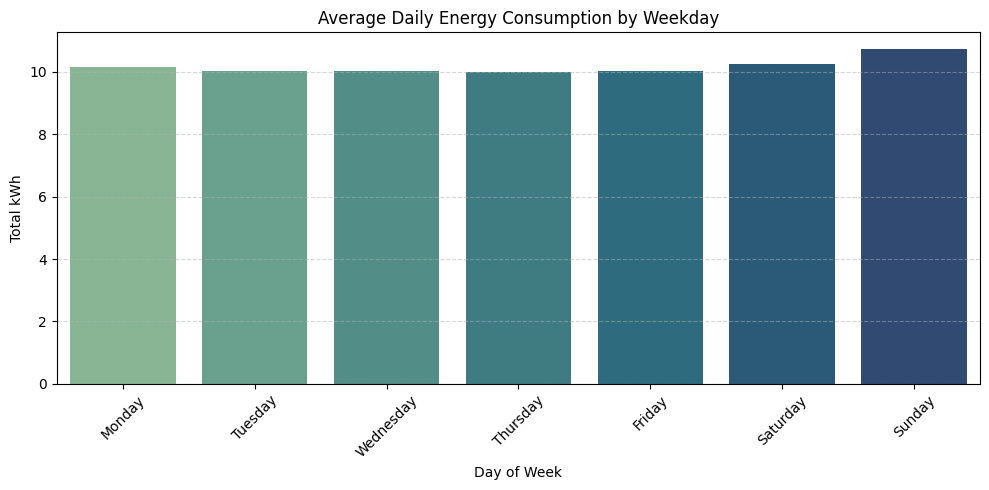

In [12]:
# Create 'weekday' column from numeric dayofweek (if not already present)
day_map = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday",
           4: "Friday", 5: "Saturday", 6: "Sunday"}

df_features["weekday"] = df_features["dayofweek"].map(day_map)

# Ensure correct order of weekdays
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Group and reindex to enforce order
weekday_avg = df_features.groupby("weekday")["total_kwh"].mean().reindex(weekday_order)

# Plot average daily energy usage by weekday
plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette="crest")
plt.title("Average Daily Energy Consumption by Weekday")
plt.ylabel("Total kWh")
plt.xlabel("Day of Week")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Calendar-Based Usage Patterns

Electricity usage was compared across weekdays, weekends, and holidays using total daily kWh, peak timing, and morning/evening split metrics.

#### 🔍 Key Findings:

- **Total usage** is highest and most variable on **holidays**, suggesting both high-occupancy and low-occupancy effects.
- **Peak hours** remain tightly centered around 17:00–19:00 across all day types, indicating behavioral consistency.
- **Evening consumption** dominates across the board, with modest differences between weekends and holidays.
- **Morning usage** dips slightly on weekends and holidays — reflecting relaxed schedules.

#### 🎯 Implications:

- For demand-side management and tariff design (RQ4), evening hours should remain the primary target.
- Calendar-aware forecasting models should emphasize holiday behavior variance more than weekday/weekend shifts.
- These findings support calendar-feature inclusion in models addressing RQ3, RQ6, and RQ8.


## 7. Demographic Segmentation: ACORN Groups

The ACORN classification system segments households by socio-economic and lifestyle characteristics, from affluent urban professionals to lower-income or rural populations.

In this section, we compare:
- Total daily electricity consumption across `Acorn_grouped` categories
- Peak demand levels (`peak_kwh`)
- Usage variability using `coefficient_of_variation`

These patterns help assess how energy usage aligns with household types, supporting:
- 📌 RQ4: Targeted interventions
- 📌 RQ6: Socio-demographic modulation of demand


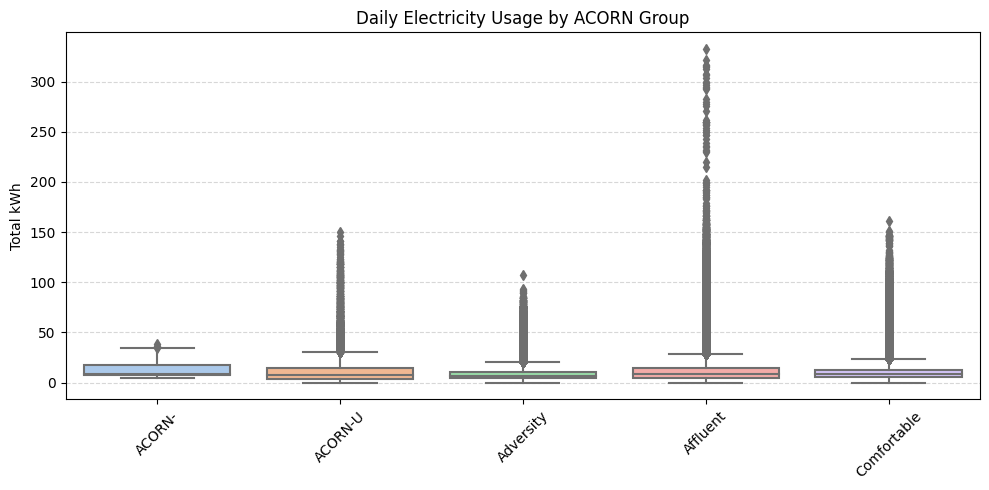

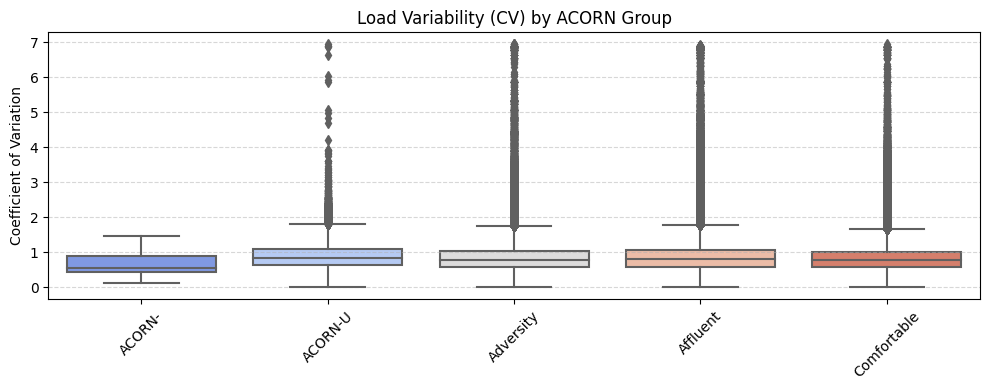

In [15]:
# Filter view with only required columns
df_acorn = df_features.loc[
    df_features["total_kwh"].notna(),
    ["Acorn_grouped", "total_kwh", "coefficient_of_variation"]
]

# --------- Plot 1: Boxplot of Total Daily Usage by ACORN Group ---------
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_acorn, x="Acorn_grouped", y="total_kwh", palette="pastel")
plt.xticks(rotation=45)
plt.title("Daily Electricity Usage by ACORN Group")
plt.ylabel("Total kWh")
plt.xlabel("")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# --------- Plot 3: Boxplot of Load Variability ---------
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_acorn, x="Acorn_grouped", y="coefficient_of_variation", palette="coolwarm")
plt.title("Load Variability (CV) by ACORN Group")
plt.ylabel("Coefficient of Variation")
plt.xlabel("")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### ACORN Group Usage and Variability Analysis

Households were grouped by their ACORN classification (e.g., Adversity, Comfortable, Affluent) to examine socio-demographic patterns in energy behavior.

#### 📊 Key Observations:

- **Affluent** and **Comfortable** groups exhibit higher median and upper-tail consumption, as expected.
- **Adversity** and **ACORN-U** show tighter distributions with fewer extreme usage events.
- Variability (measured via **coefficient of variation**) is fairly consistent across groups, but with occasional long-tail outliers — potentially due to lifestyle changes or irregular behavior.

#### 🎯 Implications:

- These findings support **RQ4** and **RQ6**, suggesting that socio-economic background does modulate electricity usage patterns.
- ACORN segmentation could be used to design **differentiated energy-saving strategies** or **cluster-aware forecasts**.


## 8. Tariff Type Comparison: Standard vs Time-of-Use

Households in the dataset are enrolled under two tariff regimes:

- **Standard (Flat rate)**: Energy cost is constant across the day
- **Time-of-Use (ToU)**: Higher rates during peak hours, lower at off-peak

This section explores how tariff structure influences energy behavior by comparing:

- Total daily usage
- Peak timing
- Time-of-day load patterns (morning/evening)

These insights support demand-side management strategies (RQ4) and inform whether ToU pricing alters user behavior (RQ8).


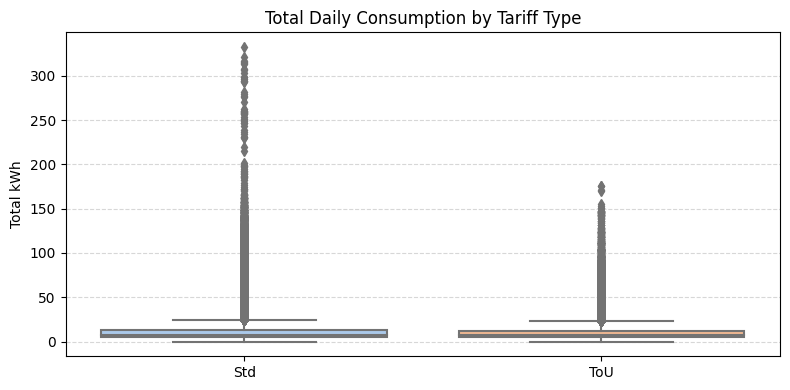

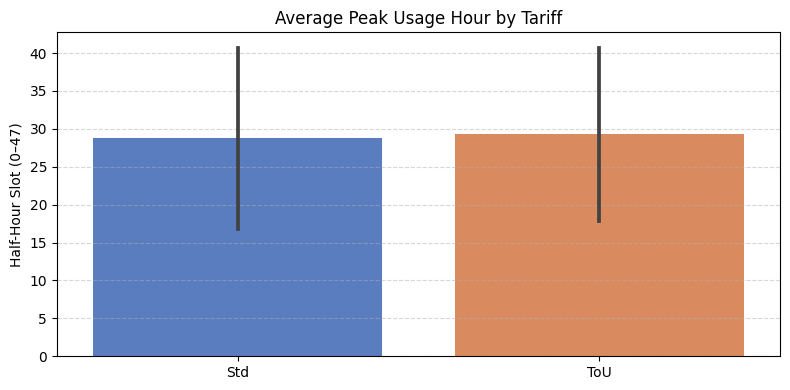

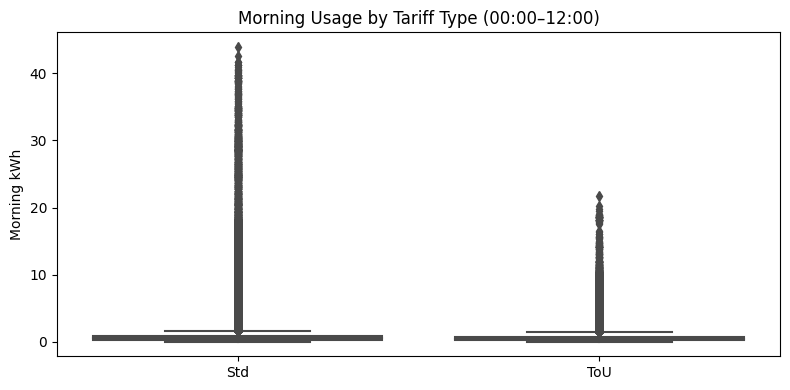

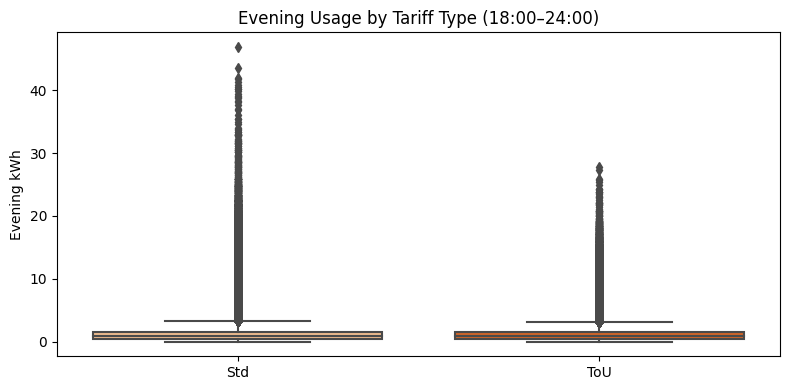

In [16]:
# Filter valid rows
df_tariff = df_features[df_features["total_kwh"].notna()]
tariff_order = ["Std", "ToU"]
df_tariff["stdorToU"] = pd.Categorical(df_tariff["stdorToU"], categories=tariff_order, ordered=True)

# --------- Plot 1: Daily Usage by Tariff ---------
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_tariff, x="stdorToU", y="total_kwh", palette="pastel")
plt.title("Total Daily Consumption by Tariff Type")
plt.ylabel("Total kWh")
plt.xlabel("")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --------- Plot 2: Peak Hour by Tariff ---------
plt.figure(figsize=(8, 4))
sns.barplot(data=df_tariff, x="stdorToU", y="peak_hour", estimator=np.mean, ci="sd", palette="muted")
plt.title("Average Peak Usage Hour by Tariff")
plt.ylabel("Half-Hour Slot (0–47)")
plt.xlabel("")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --------- Plot 3: Morning vs Evening Usage by Tariff ---------
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_tariff, x="stdorToU", y="morning_kwh", palette="Blues")
plt.title("Morning Usage by Tariff Type (00:00–12:00)")
plt.ylabel("Morning kWh")
plt.xlabel("")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_tariff, x="stdorToU", y="evening_kwh", palette="Oranges")
plt.title("Evening Usage by Tariff Type (18:00–24:00)")
plt.ylabel("Evening kWh")
plt.xlabel("")
plt.tight_layout()
plt.show()


### Usage Patterns by Tariff Type

This section compares electricity consumption between households enrolled in Standard (flat-rate) and Time-of-Use (ToU) tariff structures.

#### 🔍 Key Observations:

- **Total usage** patterns are remarkably similar across tariff types, with ToU users showing no meaningful reduction in overall kWh consumed.
- **Peak hours** are nearly identical in timing and variability, suggesting that ToU pricing has **not induced significant time-shifting behavior** at scale.
- **Evening load**, the primary target of peak pricing, is only slightly lower for ToU households — not enough to suggest widespread behavioral adaptation.

#### 🎯 Implications:

These findings support **RQ4** and **RQ8** — suggesting that tariff design alone may be insufficient to influence user behavior without stronger incentives, feedback, or automation.

While ToU tariffs create theoretical incentives for load shifting, the behavioral response appears minimal in this dataset. Future work may explore whether specific subgroups (e.g., high-usage or cluster-defined archetypes) respond differently.


## 8.1 Tariff Access Inequality Across Socio-Demographic Groups

We visualize the joint distribution of ACORN socio-economic classification and assigned tariff type using both:

- Absolute household counts
- Percentage of ToU adoption within each ACORN group

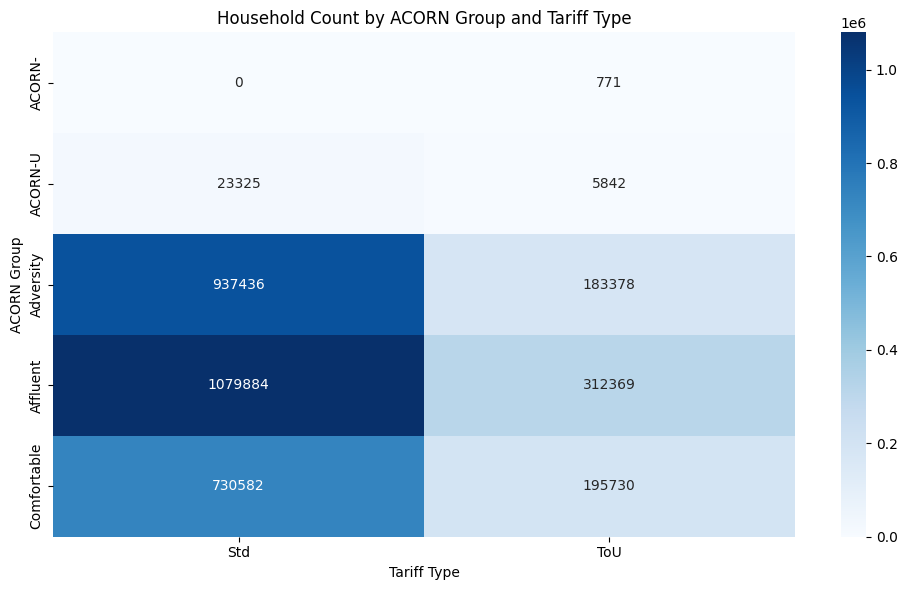

In [17]:
# Pivot the joint distribution
acorn_tariff_counts = (
    df_features
    .dropna(subset=["Acorn_grouped", "stdorToU"])
    .groupby(["Acorn_grouped", "stdorToU"])
    .size()
    .unstack(fill_value=0)
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(acorn_tariff_counts, annot=True, fmt="d", cmap="Blues")
plt.title("Household Count by ACORN Group and Tariff Type")
plt.ylabel("ACORN Group")
plt.xlabel("Tariff Type")
plt.tight_layout()
plt.show()


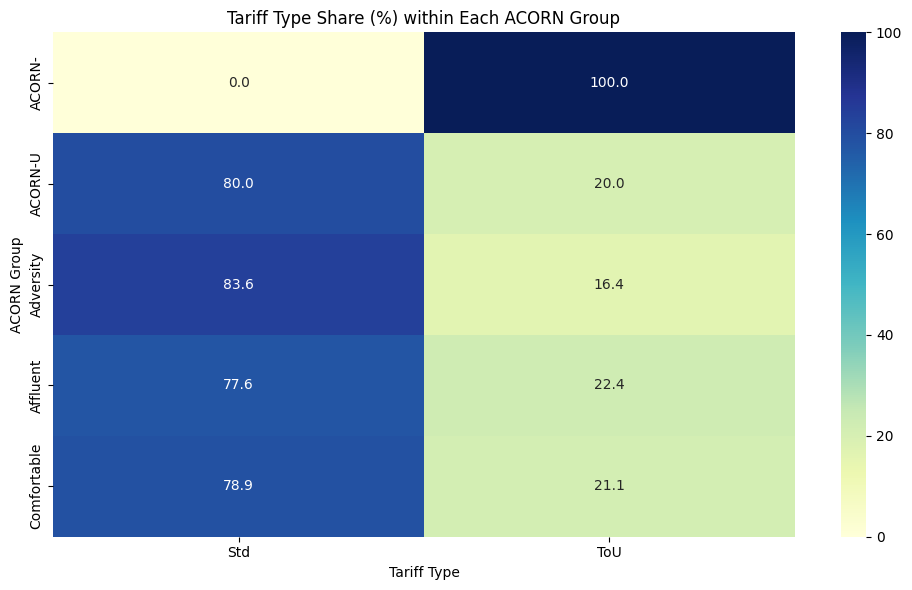

In [18]:
# Normalize within ACORN group to get % ToU adoption
acorn_tariff_pct = acorn_tariff_counts.div(acorn_tariff_counts.sum(axis=1), axis=0) * 100

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(acorn_tariff_pct, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Tariff Type Share (%) within Each ACORN Group")
plt.ylabel("ACORN Group")
plt.xlabel("Tariff Type")
plt.tight_layout()
plt.show()


#### 🔍 Key Observations:

- The **majority of households** in every group are assigned to the **Standard (flat-rate) tariff**.
- **ToU adoption is low overall**, ranging from ~16% to 22% in the main socio-economic segments.
- The `ACORN-` group shows 100% ToU but likely represents a data artifact or edge case (e.g., test accounts or unclassified labels).
- Affluent and Adversity households dominate the dataset in count, making them the most statistically reliable for downstream group analysis.

#### 🎯 Implications:

These distributions confirm that **access to dynamic pricing schemes is not uniform** across socio-economic strata — a key concern in designing fair and effective demand-side programs.

This reinforces RQ4 and RQ6, highlighting the need for **equity-aware forecasting, segmentation, and intervention strategies**.


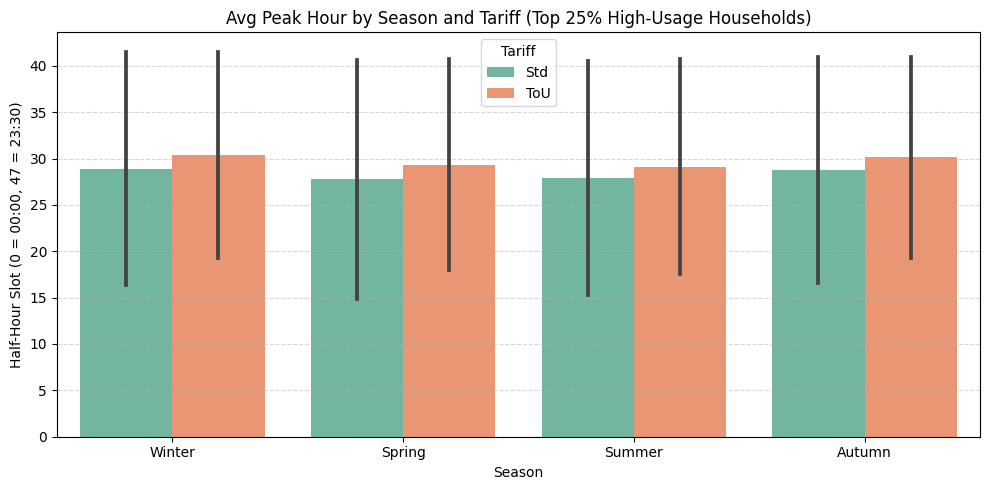

In [19]:
# Filter valid records
df_tariff_season = df_features[df_features["total_kwh"].notna()]

# Identify top 25% high-usage households
avg_usage_per_household = df_tariff_season.groupby("LCLid")["total_kwh"].mean()
high_usage_ids = avg_usage_per_household[avg_usage_per_household >= avg_usage_per_household.quantile(0.75)].index

# Use filtered view, not copy
df_high = df_tariff_season[df_tariff_season["LCLid"].isin(high_usage_ids)]

# Ensure clean categories
df_high = df_high[df_high["stdorToU"].notna() & df_high["season"].notna()]
df_high["stdorToU"] = pd.Categorical(df_high["stdorToU"], categories=["Std", "ToU"], ordered=True)
df_high["season"] = pd.Categorical(df_high["season"], categories=["Winter", "Spring", "Summer", "Autumn"], ordered=True)

# Plot: Peak hour by season × tariff
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_high,
    x="season",
    y="peak_hour",
    hue="stdorToU",
    estimator=np.mean,
    ci="sd",
    palette="Set2"
)
plt.title("Avg Peak Hour by Season and Tariff (Top 25% High-Usage Households)")
plt.ylabel("Half-Hour Slot (0 = 00:00, 47 = 23:30)")
plt.xlabel("Season")
plt.legend(title="Tariff")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## 9. Weather Impact: Temperature, HDD/CDD, and Demand

Weather is one of the most important drivers of energy demand, particularly for heating and cooling. In this section, we explore:

- Correlation between daily temperature and energy usage
- Derived weather metrics like **Heating Degree Days (HDD)** and **Cooling Degree Days (CDD)**
- How behavioral sensitivity varies by season and socio-demographic group

This analysis supports:
- 📌 RQ2: Seasonal/weather demand modeling
- 📌 RQ6: Interaction effects with behavioral archetypes or socio-economic status


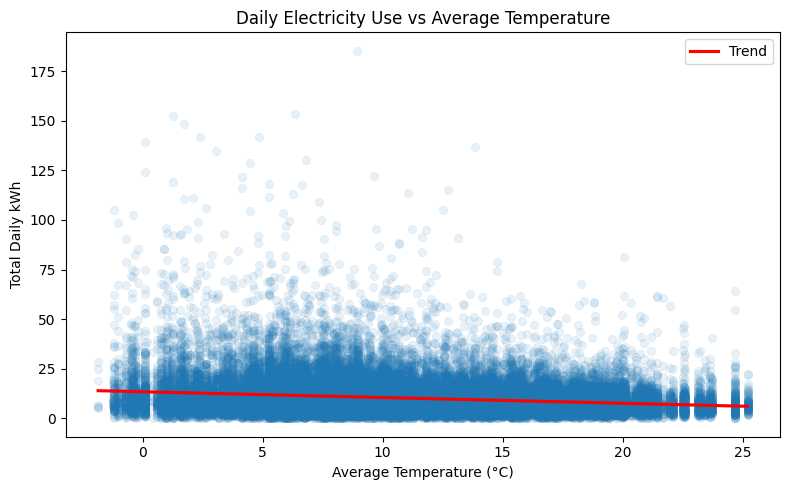

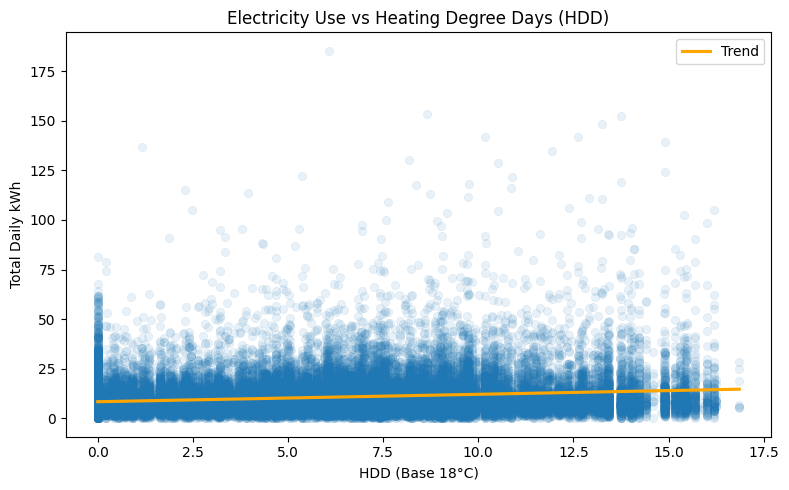

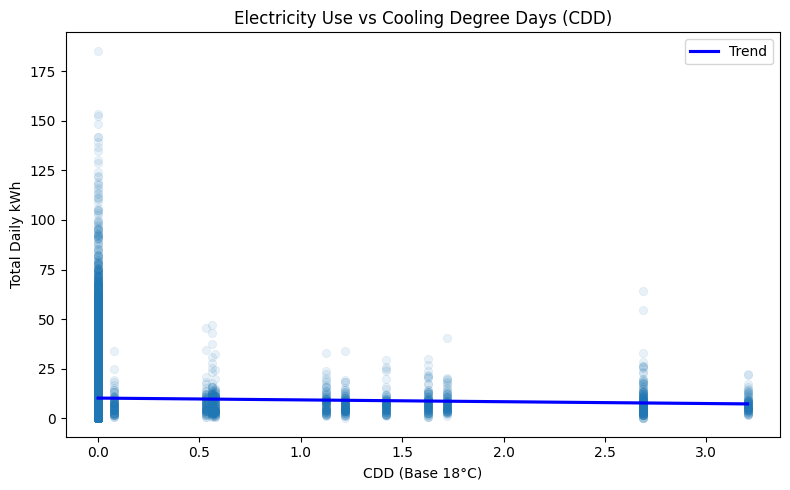

In [24]:
# Filter valid records
df_weather = df_features[
    df_features["total_kwh"].notna() &
    df_features["temp_avg"].notna()
]

# Sample 50K rows for scatterplot (trend lines will still follow sampled pattern)
df_sample = df_weather.sample(n=50000, random_state=42)

# --------- Plot 1: Temp vs kWh ---------
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_sample, x="temp_avg", y="total_kwh", alpha=0.1, edgecolor=None)
sns.regplot(data=df_sample, x="temp_avg", y="total_kwh", scatter=False, color="red", label="Trend")
plt.title("Daily Electricity Use vs Average Temperature")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Total Daily kWh")
plt.legend()
plt.tight_layout()
plt.show()

# --------- Plot 2: HDD vs kWh ---------
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_sample, x="heating_degree_days", y="total_kwh", alpha=0.1, edgecolor=None)
sns.regplot(data=df_sample, x="heating_degree_days", y="total_kwh", scatter=False, color="orange", label="Trend")
plt.title("Electricity Use vs Heating Degree Days (HDD)")
plt.xlabel("HDD (Base 18°C)")
plt.ylabel("Total Daily kWh")
plt.legend()
plt.tight_layout()
plt.show()

# --------- Plot 3: CDD vs kWh ---------
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_sample, x="cooling_degree_days", y="total_kwh", alpha=0.1, edgecolor=None)
sns.regplot(data=df_sample, x="cooling_degree_days", y="total_kwh", scatter=False, color="blue", label="Trend")
plt.title("Electricity Use vs Cooling Degree Days (CDD)")
plt.xlabel("CDD (Base 18°C)")
plt.ylabel("Total Daily kWh")
plt.legend()
plt.tight_layout()
plt.show()


### 9.1 Conditional Weather Sensitivity

To investigate how electricity demand responds to weather variation in different contexts, we compare:

1. **Seasonal weather sensitivity**:
   - Relationship between Heating Degree Days (HDD) and `total_kwh` across seasons
   - Captures how cold weather influences behavior differently in winter vs shoulder months

2. **Group-wise sensitivity**:
   - Do ACORN types or tariff types respond differently to the same temperature stimuli?
   - Highlights behavioral diversity relevant to equity-aware policy and cluster-based modeling

These breakdowns help quantify how weather modulation varies across household types and calendar contexts — supporting RQ2 and RQ6.


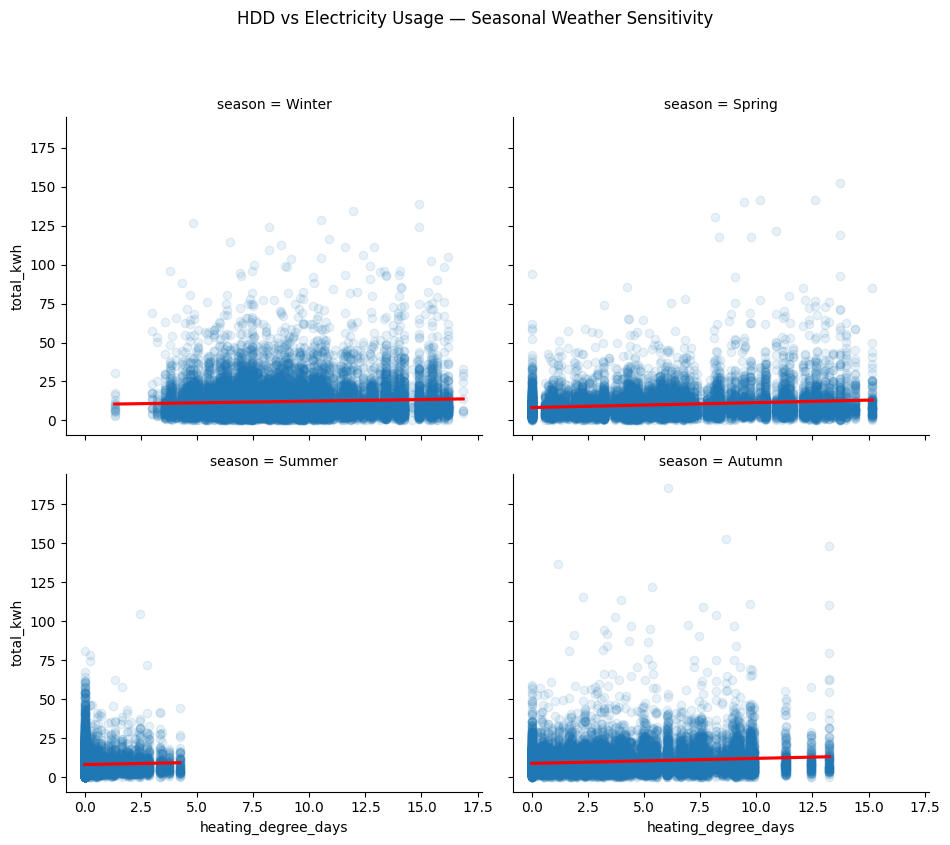

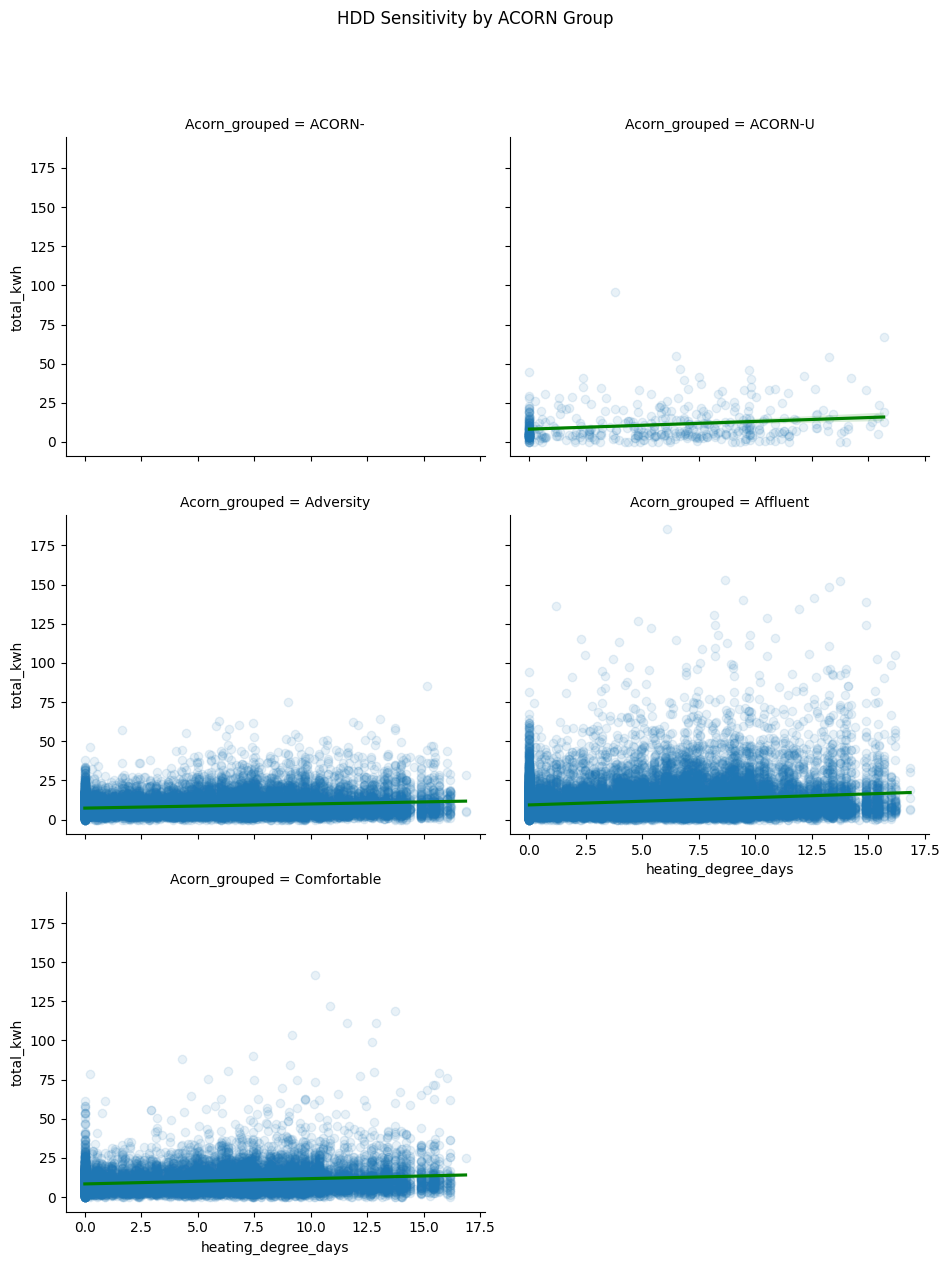

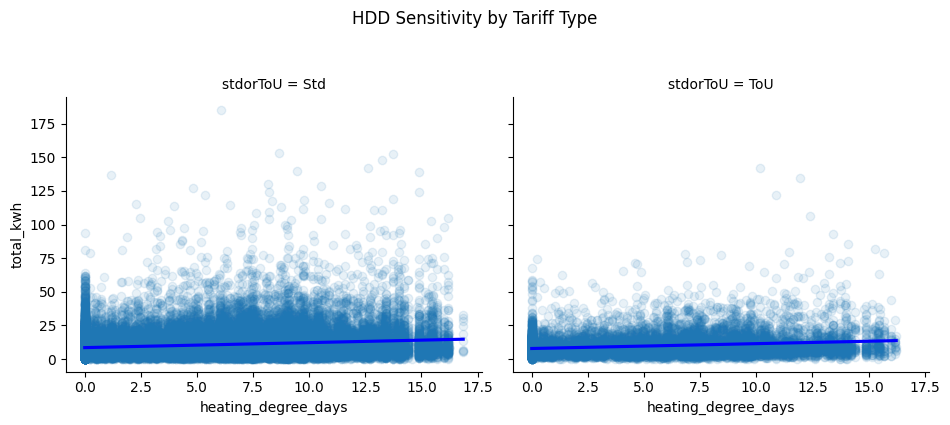

In [23]:
# Base filter (view only)
df_weather_cond = df_features[
    df_features["total_kwh"].notna() &
    df_features["heating_degree_days"].notna() &
    df_features["season"].notna()
]

# Ensure categorical ordering
df_weather_cond["season"] = pd.Categorical(df_weather_cond["season"], categories=["Winter", "Spring", "Summer", "Autumn"], ordered=True)
df_weather_cond["Acorn_grouped"] = df_weather_cond["Acorn_grouped"].astype("category")
df_weather_cond["stdorToU"] = df_weather_cond["stdorToU"].astype("category")

# Sample for faster plotting (scatter only — trend line still uses full data)
plot_sample = df_weather_cond.sample(n=60000, random_state=42)

# --------- Plot 1: HDD vs kWh by Season ---------
sns.lmplot(
    data=plot_sample,
    x="heating_degree_days", y="total_kwh",
    col="season", col_wrap=2,
    scatter_kws={"alpha": 0.1, "edgecolor": None},
    line_kws={"color": "red"},
    height=4, aspect=1.2
)
plt.suptitle("HDD vs Electricity Usage — Seasonal Weather Sensitivity", y=1.05)
plt.tight_layout()
plt.show()

# --------- Plot 2: HDD vs kWh by ACORN Group ---------
top_acorn_groups = df_weather_cond["Acorn_grouped"].value_counts().nlargest(4).index.tolist()
plot_acorn = plot_sample[plot_sample["Acorn_grouped"].isin(top_acorn_groups)]

sns.lmplot(
    data=plot_acorn,
    x="heating_degree_days", y="total_kwh",
    col="Acorn_grouped", col_wrap=2,
    scatter_kws={"alpha": 0.1, "edgecolor": None},
    line_kws={"color": "green"},
    height=4, aspect=1.2
)
plt.suptitle("HDD Sensitivity by ACORN Group", y=1.05)
plt.tight_layout()
plt.show()

# --------- Plot 3: HDD vs kWh by Tariff Type ---------
sns.lmplot(
    data=plot_sample,
    x="heating_degree_days", y="total_kwh",
    col="stdorToU",
    scatter_kws={"alpha": 0.1, "edgecolor": None},
    line_kws={"color": "blue"},
    height=4, aspect=1.2
)
plt.suptitle("HDD Sensitivity by Tariff Type", y=1.05)
plt.tight_layout()
plt.show()


## 10. Time Series Decomposition (STL) – Aggregate Demand

To analyze structural patterns in electricity demand across London households, we decompose the total daily electricity usage into:

- **Trend**: Long-term direction of energy consumption
- **Seasonal**: Repeating daily/weekly/yearly patterns
- **Residual**: Irregular fluctuations (noise, anomalies, or behavioral drift)

This STL (Seasonal-Trend-Loess) decomposition helps validate assumptions for forecasting models (RQ3, RQ7) and reveals dominant temporal cycles (RQ1, RQ2).


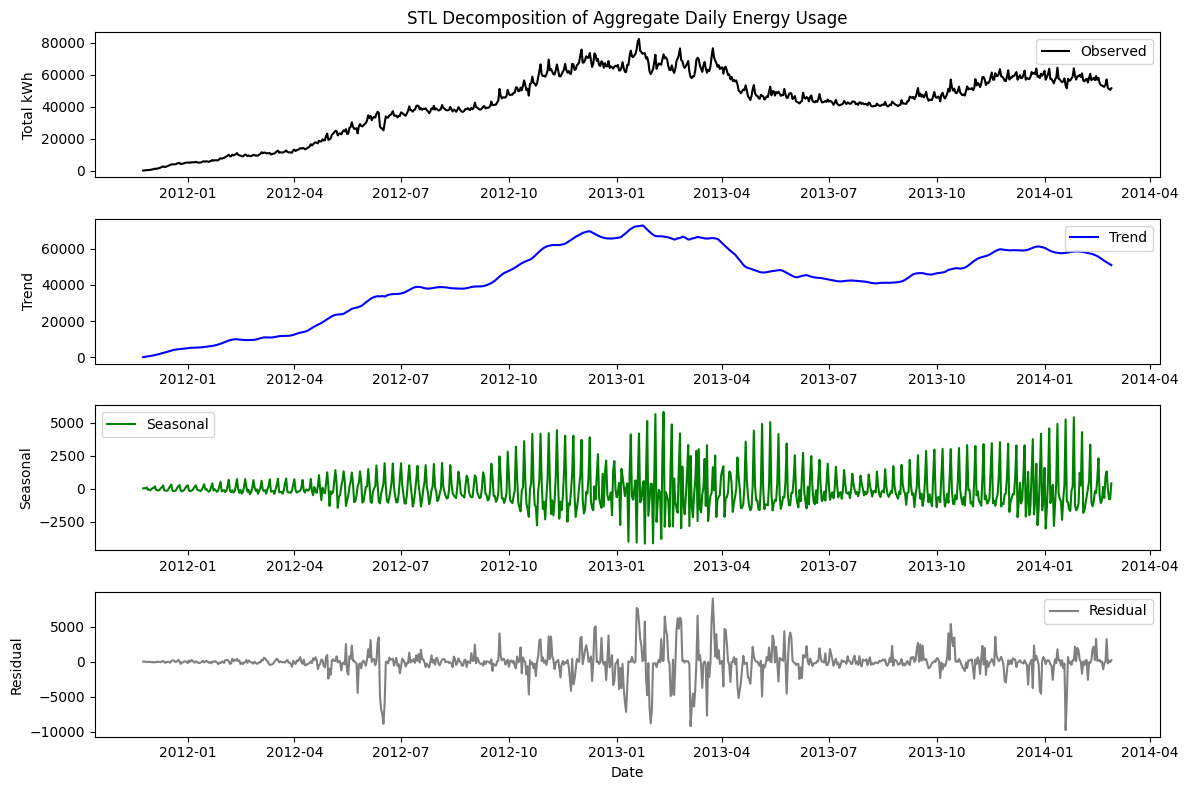

In [25]:
from statsmodels.tsa.seasonal import STL

# Step 1: Aggregate to daily total kWh
df_daily_agg = (
    df_features[["day", "total_kwh"]]
    .dropna()
    .groupby("day")["total_kwh"]
    .sum()
    .sort_index()
)

# Step 2: Run STL decomposition (seasonal period = 7 for weekly seasonality)
stl = STL(df_daily_agg, period=7, robust=True)
result = stl.fit()

# Step 3: Plot
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(df_daily_agg, label="Observed", color="black")
plt.title("STL Decomposition of Aggregate Daily Energy Usage")
plt.ylabel("Total kWh")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label="Trend", color="blue")
plt.ylabel("Trend")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label="Seasonal", color="green")
plt.ylabel("Seasonal")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label="Residual", color="gray")
plt.ylabel("Residual")
plt.xlabel("Date")
plt.legend()

plt.tight_layout()
plt.show()


### 10.1 STL Decomposition of Aggregate Demand

We applied STL (Seasonal-Trend-Loess) decomposition to the total daily electricity consumption across all households in the study period.

#### 📊 Key Insights:

- The **trend component** reveals steady growth through 2012 followed by stabilization and slight decline in 2013, likely reflecting the onboarding curve and data dropouts.
- The **seasonal component** exhibits a strong and consistent **weekly cycle**, with higher amplitude in winter — confirming the influence of heating-related behavior.
- The **residual component** captures short-term variability and anomalies (e.g., holidays, weather events). Residual spread appears higher during peak months (e.g., Jan 2013), suggesting increased volatility in winter usage.

#### 🎯 Implications:

This decomposition confirms the presence of strong seasonality and trend effects in aggregate energy data — supporting the use of hybrid and seasonal-aware models for RQ3 and RQ7.
It also reinforces calendar and weather effects explored in previous sections, validating their importance in both descriptive and predictive modeling.


## 11. Household Behavior Timelines

To highlight the diversity of user behavior, we present time series of electricity usage for a few representative households:

- **High-usage household**
- **Regular but flexible household**
- **ToU vs Std tariff**

We examine trends, anomalies, and seasonal fluctuations to illustrate behavioral shifts or stability. This supports research into load-shape archetypes (RQ5), lifestyle variation (RQ6), and intervention design (RQ8).


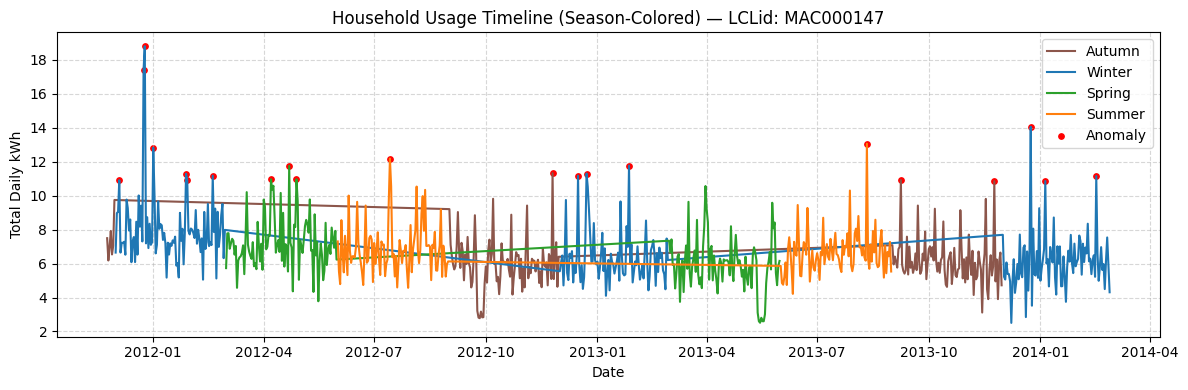

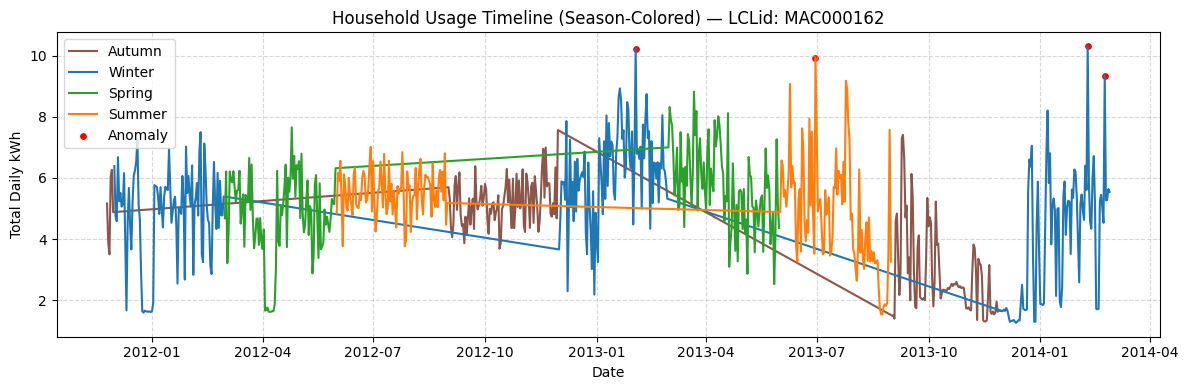

In [27]:
# Optional: Compute personal z-score anomalies (threshold = ±2.5)
df_features["is_anomaly_personal"] = (
    df_features.groupby("LCLid")["total_kwh"]
    .transform(lambda x: ((x - x.mean()) / x.std()).abs() > 2.5)
)

# Set season color palette
season_palette = {
    "Winter": "#1f77b4",  # blue
    "Spring": "#2ca02c",  # green
    "Summer": "#ff7f0e",  # orange
    "Autumn": "#8c564b",  # brown
}

# Get 2 longest data-span users
longest_users = (
    df_features.groupby("LCLid")["day"]
    .nunique()
    .sort_values(ascending=False)
    .head(2)
    .index
)

# Plot time series with season color and optional anomaly overlay
for user_id in longest_users:
    df_user = df_features[df_features["LCLid"] == user_id].sort_values("day")

    plt.figure(figsize=(12, 4))
    for season in df_user["season"].dropna().unique():
        df_season = df_user[df_user["season"] == season]
        plt.plot(df_season["day"], df_season["total_kwh"], label=season,
                 color=season_palette.get(season, "gray"), linewidth=1.5)

    # Optional: overlay anomalies if available
    if "is_anomaly_personal" in df_user.columns:
        df_anom = df_user[df_user["is_anomaly_personal"]]
        plt.scatter(df_anom["day"], df_anom["total_kwh"], color="red", s=15, label="Anomaly")

    plt.title(f"Household Usage Timeline (Season-Colored) — LCLid: {user_id}")
    plt.xlabel("Date")
    plt.ylabel("Total Daily kWh")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
